In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import pickle
from random import shuffle
from pathlib import Path
# if using a Jupyter notebook, includue:
%matplotlib inline

In [2]:
Data = pd.read_feather('Data.feather')
pids = Data['pid'].unique()
pid_groups = Data.groupby('pid')
meta_covars = ['pid','SepsisLabel']
baseline_covars = []
lab_covars = []
vital_covars = ['HR','O2Sat','Temp','SBP','MAP','DBP', 'Resp']

C:\Users\choltz\AppData\Local\Continuum\anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [3]:
Data.columns

Index(['index', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'pid'],
      dtype='object')

40336
hospital stay length: mean 38.48200119000396 std 22.795923321200572


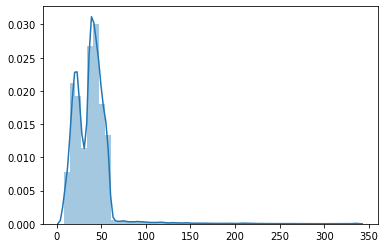

In [4]:
print(len(pids))
sns.distplot(pid_groups.size())
print('hospital stay length:', 'mean', pid_groups.size().mean(), 'std',pid_groups.size().std())

In [5]:
## prune hospital stay outliers:
pids_stay_length = pid_groups.size()
pids = pids_stay_length[np.abs(pids_stay_length-pids_stay_length.mean()) <= (3*pids_stay_length.std())]
pids = pids_stay_length[pids_stay_length > 7]

In [6]:
Data = Data[Data['pid'].isin(pids.index)]

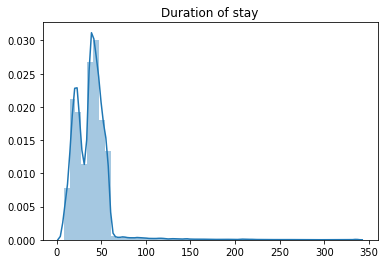

In [7]:
plt.title("Duration of stay")
sns.distplot(Data.groupby('pid').size())

In [8]:
## sepsis pids remove those who get into the hospital with sepsis
sepsis_pids = (Data.groupby('pid')['SepsisLabel'].sum() > 1)[(Data.groupby('pid')['SepsisLabel'].sum() > 1) == True].index.unique().tolist()
non_sepsis_pids = [pid for pid in pids.index if pid not in sepsis_pids]

In [9]:
len(sepsis_pids)

2927

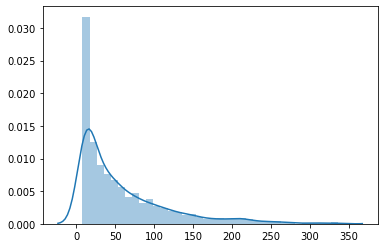

In [10]:
sns.distplot(Data[Data['pid'].isin(sepsis_pids)].groupby('pid').size())

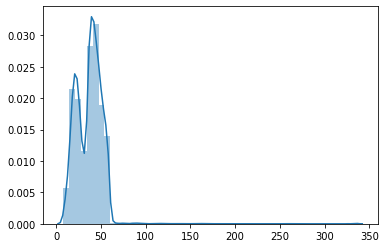

In [11]:
sns.distplot(Data[Data['pid'].isin(non_sepsis_pids)].groupby('pid').size())

In [12]:
print(Data[Data['pid'].isin(sepsis_pids)].groupby('pid').size().mean())
print(Data[Data['pid'].isin(sepsis_pids)].groupby('pid').size().std())

58.74615647420567
59.16422454705538


In [13]:
print(Data[Data['pid'].isin(non_sepsis_pids)].groupby('pid').size().mean())
print(Data[Data['pid'].isin(non_sepsis_pids)].groupby('pid').size().std())

36.89646876420113
15.870526473682462


In [15]:
print('sepsis:', len(sepsis_pids), 'not sepsis:', len(not_sepsis_pids))

NameError: name 'not_sepsis_pids' is not defined

In [ ]:
## time to sepsis
plt.title("Time to sepsis")
sns.distplot(Data[Data.pid.isin(sepsis_pids)].groupby('pid').size() - Data[Data.pid.isin(sepsis_pids)].groupby('pid').SepsisLabel.sum())

In [16]:
# no sepsis in first 7 days
sepsis_pids = (Data[Data.pid.isin(sepsis_pids)].groupby('pid').size() - Data[Data.pid.isin(sepsis_pids)].groupby('pid').SepsisLabel.sum() > 7)[(Data[Data.pid.isin(sepsis_pids)].groupby('pid').size() - Data[Data.pid.isin(sepsis_pids)].groupby('pid').SepsisLabel.sum() > 7)].index.tolist()

In [17]:
len(non_sepsis_pids)

37409

In [18]:
Data = Data[Data.pid.isin(sepsis_pids + non_sepsis_pids)]

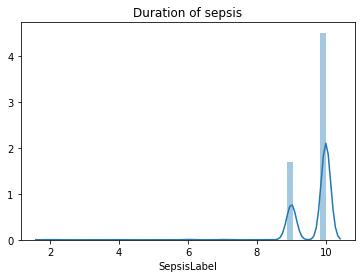

In [19]:
## duration of sepsis
plt.title("Duration of sepsis")
sns.distplot(Data[Data.pid.isin(sepsis_pids)].groupby('pid').SepsisLabel.sum())

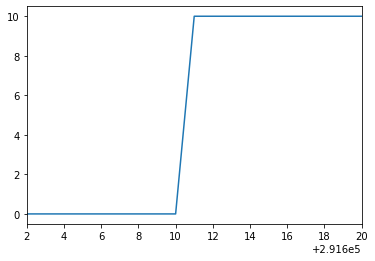

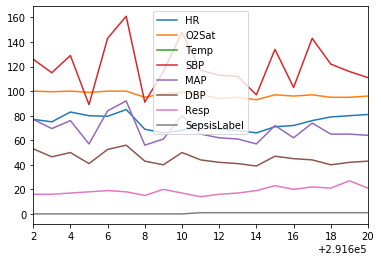

In [20]:
## plots of sepsis cases vital covariates
(Data[Data['pid'] == sepsis_pids[3]]['SepsisLabel']*10).plot()
Data[Data['pid'] == sepsis_pids[3]][vital_covars + ['SepsisLabel']].plot()

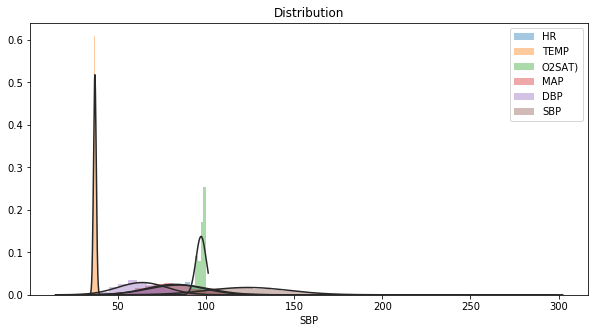

In [21]:
train_sample = Data.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Distribution")
ax = sns.distplot(train_sample['HR'].dropna(), label='HR', kde=False, fit=stats.norm)
ax = sns.distplot(train_sample['Temp'].dropna(), label='TEMP', kde=False, fit=stats.norm)
ax = sns.distplot(train_sample['O2Sat'].dropna(), label='O2SAT)', kde=False, fit=stats.norm)
ax = sns.distplot(train_sample['MAP'].dropna(), label='MAP', kde=False, fit=stats.norm)
ax = sns.distplot(train_sample['DBP'].dropna(), label='DBP', kde=False, fit=stats.norm)
ax = sns.distplot(train_sample['SBP'].dropna(), label='SBP', kde=False, fit=stats.norm)
ax.legend()

In [22]:
Data.isnull().sum()/Data.shape[0]

index               0.000000
HR                  0.098690
O2Sat               0.130512
Temp                0.661465
SBP                 0.145438
MAP                 0.124436
DBP                 0.312877
Resp                0.153402
EtCO2               0.963053
BaseExcess          0.946130
HCO3                0.958276
FiO2                0.917135
pH                  0.931113
PaCO2               0.944762
SaO2                0.965703
AST                 0.983965
BUN                 0.931579
Alkalinephos        0.984119
Calcium             0.941386
Chloride            0.954788
Creatinine          0.939230
Bilirubin_direct    0.998105
Glucose             0.829001
Lactate             0.973644
Magnesium           0.937108
Phosphate           0.960014
Potassium           0.907208
Bilirubin_total     0.985257
TroponinI           0.990543
Hct                 0.911732
Hgb                 0.926410
PTT                 0.970732
WBC                 0.936153
Fibrinogen          0.993456
Platelets     

In [23]:
# parse covars - remove index, Unit1, Unit2, HospAdmTime
columns = Data.columns.tolist()
ignored_covars = ['Unit1', 'Unit2', 'HospAdmTime', 'index']

label = ['SepsisLabel']
vital_covars = ['HR','O2Sat','Temp','SBP','MAP','DBP', 'Resp']
idx_covars = ['pid']
baseline_covars = ['Age', 'Gender', 'ICULOS']
lab_covars = [col for col in columns if col not in ignore + label + vital_covars + idx_covars + baseline_covars]

NameError: name 'ignore' is not defined

In [24]:
class Dataset:
    def __init__(self):
        self.groups = {}
        self.sepsis_pids = []
        self.non_sepsis_pids = []
        for group_name in ('train', 'val', 'test'):
            self.groups[group_name] = {
                "pid_list": [],
                "vital_features_list": [],
                "baseline_features_list": [],
                "lab_features_list": [],
                "ignored_features_list": [],
                "labels_list": []
            }
        
    @classmethod
    def generate_pid_split(cls, data, split, balance_tr_data = False, sp=None, nsp=None):
        # balance data by undersampling non-sepsis cases
        # split given as int
        self = cls()
        pids = data.pid.unique().tolist()
        shuffle(pids)
        sepsis_pids = sp
        non_sepis_pids = nsp
        if sepsis_pids is not None:
            shuffle(sepsis_pids)
        if non_sepsis_pids is not None:
            shuffle(non_sepsis_pids)
            
        if balance_tr_data:
            #sepsis_pids, non_sepsis_pids = pids
            spl = int(split * len(sepsis_pids))
            tst_pids = sepsis_pids[:spl]
            #val_pids = sepsis_pids[spl:2*spl]
            val_pids = []
            tr_pids = sepsis_pids[spl:]
            
            tst_pids.extend(non_sepsis_pids[:5*spl])
            #val_pids.extend(non_sepsis_pids[spl:2*spl])
            tr_pids.extend(non_sepsis_pids[5*spl:5*spl+int(len(tr_pids))])
            
        else:
            spl = int(split * len(pids))
            tst_pids = pids[:spl]
            val_pids = pids[spl:2*spl]
            tr_pids = pids[2*spl:]
        
        pid_grouped_data = data.groupby('pid')
        for pid, group in tqdm(pid_grouped_data, desc='splitting data...'):
            if pid in tr_pids:
                self.groups['train']['pid_list'].append(pid)
                self.groups['train']['vital_features_list'].append(group[vital_covars].reset_index())
                self.groups['train']['baseline_features_list'].append(group[baseline_covars].reset_index())
                self.groups['train']['lab_features_list'].append(group[lab_covars].reset_index())
                self.groups['train']['ignored_features_list'].append(group[ignored_covars].reset_index())
                self.groups['train']['labels_list'].append(group[label])
            elif pid in val_pids:
                self.groups['val']['pid_list'].append(pid)
                self.groups['val']['vital_features_list'].append(group[vital_covars].reset_index())
                self.groups['val']['baseline_features_list'].append(group[baseline_covars].reset_index())
                self.groups['val']['lab_features_list'].append(group[lab_covars].reset_index())
                self.groups['val']['ignored_features_list'].append(group[ignored_covars].reset_index())
                self.groups['val']['labels_list'].append(group[label])
            elif pid in tst_pids:
                self.groups['test']['pid_list'].append(pid)
                self.groups['test']['vital_features_list'].append(group[vital_covars].reset_index())
                self.groups['test']['baseline_features_list'].append(group[baseline_covars].reset_index())
                self.groups['test']['lab_features_list'].append(group[lab_covars].reset_index())
                self.groups['test']['ignored_features_list'].append(group[ignored_covars].reset_index())
                self.groups['test']['labels_list'].append(group[label])
        return self
    
    @classmethod
    def load(cls, filepath):
        filepath = Path(filepath)
        with filepath.open('rb') as f:
            return pickle.load(f)
        
    def save(self, filepath):
        filepath = Path(filepath)
        #if filepath.exists():
        #    raise FileExistsError(f"cannot write dataset to '{filepath}'; file exists")
        
        with filepath.open('wb') as f:
            pickle.dump(self, f)


In [25]:
dataset = Dataset()

In [26]:
#dataset.sepsis_pids = sepsis_pids
#dataset.non_sepsis_pids = non_sepsis_pids

In [35]:
len(non_sepsis_pids), len(sepsis_pids)

(37409, 2099)

In [29]:
dataset = dataset.generate_pid_split(Data, 0.1, True, sepsis_pids, non_sepsis_pids)
dataset.save("./dataset_balanced6.gpickle")

In [36]:
len(dataset.groups['train']['pid_list']), len(dataset.groups['test']['pid_list'])

(3780, 1254)

In [ ]:
dataset.groups['train']['labels_list'].values

In [298]:
dataset.groups['train']['vital_features_list'][3]

,index,HR,O2Sat,Temp,SBP,MAP,DBP,Resp
0,291602,77.0,100.0,NaN,126.0,77.0,53.0,16.0
1,291603,75.0,99.5,NaN,115.0,69.5,46.5,16.0
2,291604,83.0,100.0,NaN,129.0,76.0,50.0,17.0
3,291605,80.0,99.0,NaN,89.0,57.0,41.0,18.0
4,291606,79.5,100.0,NaN,143.0,84.0,52.5,19.0
5,291607,85.0,100.0,NaN,161.0,92.0,56.0,18.0
6,291608,69.0,95.0,NaN,91.0,56.0,43.0,15.0
7,291609,66.0,98.0,NaN,116.0,61.0,40.0,20.0
8,291610,68.0,99.0,NaN,148.0,80.0,50.0,17.0
9,291611,73.0,97.0,NaN,117.0,65.0,44.0,14.0


In [247]:
import seaborn as sns
import matplotlib.pyplot as plt

In [316]:
dataset.groups['train']['vital_features_list'][7].shape

(45, 8)

In [317]:
dataset.groups['train']['vital_features_list'][7][vital_covars].isnull().sum()

HR        3
O2Sat    18
Temp     37
SBP       3
MAP       3
DBP      45
Resp      3
dtype: int64

In [335]:
plotdata = dataset.groups['train']['vital_features_list'][7][vital_covars].notnull()
sns.set(style="ticks")
for i, col in enumerate(vital_covars):
    plotdata[col] = plotdata[col]*(i+1)

In [319]:
plotdata

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp
0,0,0,0,0,0,0,0
1,1,2,0,4,5,0,7
2,1,2,0,4,5,0,7
3,1,2,3,4,5,0,7
4,1,2,0,4,5,0,7
5,1,0,0,4,5,0,7
6,0,0,0,0,0,0,0
7,1,2,0,4,5,0,7
8,1,0,0,4,5,0,7
9,1,2,3,4,5,0,7


Text(0.5, 1.0, 'Patient p000043 missing vital sign values')

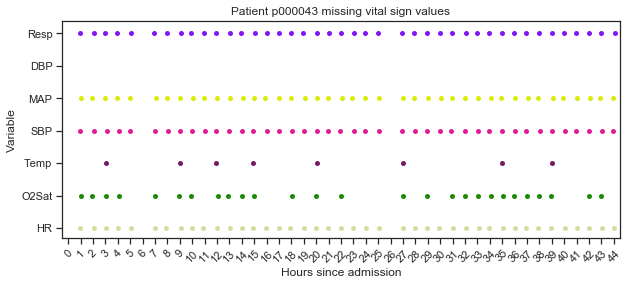

In [353]:
plt.figure(figsize=(10, 4))
colors = np.random.random((plotdata.shape[1],3))
for i, col in enumerate(vital_covars):
    s = sns.stripplot(x='index', y=col, data=plotdata[plotdata[vital_covars]!= 0].reset_index(), size = 5, color =colors[i])
s.set_xticklabels(labels=plotdata[vital_covars].index,rotation=45)
s.set_yticklabels(labels=['']+vital_covars)
plt.ylabel("Variable")
plt.xlabel("Hours since admission")
plt.title("Patient " + dataset.groups['train']['pid_list'][7] + " missing vital sign values")